In [1]:
%load_ext autoreload
%autoreload 2

from scripts import process
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import rasterio
from rasterio.features import rasterize
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import dasymetric

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

In [4]:
cov_path = f"data/gridded_pop/tha_ppp_2020_UNadj_constrained_100m.tif"
with rasterio.open(cov_path) as src:
    worldpop = src.read(1).astype(np.float32)

worldpop = np.clip(worldpop, 0, None)

display(worldpop)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(16425, 8886), dtype=float32)

In [2]:
# === CONFIGURATION ===
raster_path = "data/gridded_pop/tha_ppp_2020_proj32647.tif"
hospital_csv = "data/gridded_pop/hosmap.csv"
output_shp = "output/population_grid_epsg32647.shp"
pop_nhso_path = "data/gridded_pop/nhso_pop_2024.csv"
pop_dopa_path = "data/gridded_pop/dopa_pop_2020.csv"
dist_polygon = "data/gridded_pop/tha_adm/tha_admbnda_adm2_rtsd_20220121.shp"
subdist_polygon = "data/gridded_pop/tha_adm/tha_admbnda_adm3_rtsd_20250605.shp"
value_column = "value"

GRID_RES = 100  # in meters
target_crs = "EPSG:32647"

merge_map = {
    '1005': '1030', # บางเขน -> จัตุจักร
    '1045': '1017', # วังทองหลาง -> ห้วยขวาง
    '1913': '1901', # เฉลืมพระเกียรติ -> สระบุรี
    '6014': '6015' # แม่เปิน -> ชุมตาบง
}

In [3]:
pop_nhso = pd.read_csv(pop_nhso_path)
hos = pd.read_csv(hospital_csv)

pop_nhso['hcode'] = pop_nhso['hospital_code'].apply(lambda x: str(x[4:]))
pop_nhso = pop_nhso.merge(hos[['hcode', 'hname', 'prov', 'ampr', 'tumbon']], how='left', on='hcode')
pop_nhso = pop_nhso[~pop_nhso['tumbon'].isnull()]
pop_nhso['prov'] = pop_nhso['prov'].apply(lambda x: 'กรุงเทพฯ' if x in ['กรมแพทย์ทหารอากาศ', 'กรมแพทย์ทหารเรือ'] else x)
pop_nhso['prov'] = pop_nhso['prov'].apply(lambda x: 'กรุงเทพมหานคร' if x in ['กรุงเทพฯ'] else x)

pop_dopa, _, _ = process.DataCleaning.clean('dopa_pop_2020', 'data/gridded_pop', 'output', clear=True, export_df=False)
pop_dopa['pop_total'] = pd.to_numeric(pop_dopa['pop_total'].str.replace(',', ''), errors='coerce')
pop_dopa['dist_id_adj'] = pop_dopa['subdist_id'].astype(str).str[:4]
pop_dopa['dist_id'] = pop_dopa['dist_id'].astype(str)
dist_id_dict = dict(zip(pop_dopa['dist_id'], pop_dopa['dist']))
pop_dist = pop_dopa.groupby(['prov', 'dist_id_adj'])['pop_total'].sum().reset_index()
pop_dist['dist'] = pop_dist['dist_id_adj'].map(dist_id_dict)
pop_dist = pop_dist[pop_dist['dist_id_adj'] != '0']
pop_dist['prov'] = pop_dist['prov'].replace(r'^จังหวัด', '', regex=True)
pop_dist['dist'] = pop_dist['dist'].replace(r'^อำเภอ', '', regex=True)
pop_dist['dist'] = pop_dist['dist'].replace(r'^ท้องถิ่น', '', regex=True)

pop_dist_uc = pop_nhso.groupby(['prov', 'ampr'])['m_population'].sum().reset_index()
pop_dist_uc = pop_dist_uc.merge(pop_dist[['prov', 'dist', 'dist_id_adj', 'pop_total']], how='left', left_on=['prov', 'ampr'], right_on=['prov', 'dist'])
pop_dist_uc['%_uc'] = pop_dist_uc['m_population'] / pop_dist_uc['pop_total']

districts = gpd.read_file(dist_polygon).to_crs(epsg=4326)
districts['ADM2_PCODE'] = districts['ADM2_PCODE'].astype(str).str[2:]
gdf_dist_uc = districts[['ADM2_PCODE', 'ADM2_TH', 'ADM1_TH', 'geometry']].merge(pop_dist_uc, how='left', left_on=['ADM2_PCODE'], right_on=['dist_id_adj'])

pop_dopa['subdist_id'] = pop_dopa['subdist_id'].astype(str)
pop_subdist = pop_dopa[pop_dopa['subdist_id'] != '0'].groupby(['prov', 'dist_id_adj', 'subdist_id'])['pop_total'].sum().reset_index()
pop_subdist['dist_id_adj'] = pop_subdist['dist_id_adj'].replace(merge_map)
pop_subdist_uc = pop_subdist.merge(pop_dist_uc[['dist_id_adj', '%_uc']], how='left', on='dist_id_adj')

pop_subdist_uc['m_population'] = round(pop_subdist_uc['pop_total'] * pop_subdist_uc['%_uc'])

subdistricts = gpd.read_file(subdist_polygon).to_crs(epsg=4326)
subdistricts['ADM3_PCODE'] = subdistricts['ADM3_PCODE'].apply(lambda x: f'{str(x)[2:]}00')
gdf_subdist_uc = subdistricts[['ADM3_PCODE', 'ADM3_TH', 'ADM2_TH', 'ADM1_TH', 'geometry']].merge(pop_subdist_uc, how='left', left_on=['ADM3_PCODE'], right_on=['subdist_id'])
gdf_subdist_uc = gdf_subdist_uc.to_crs("EPSG:32647")
gdf_subdist_uc['area_km2'] = gdf_subdist_uc.geometry.area / 1e6  # convert m² to km²
gdf_subdist_uc['density'] = gdf_subdist_uc['m_population'] / gdf_subdist_uc['area_km2']

display(gdf_dist_uc[gdf_dist_uc['pop_total'].isna()])
display(gdf_subdist_uc[gdf_subdist_uc['m_population'].isna()])

File name                : dopa_pop_2020
Path to data dictionary  : data/gridded_pop/data_dict-dopa_pop_2020.xlsx
Path to cleaned dataset  : None


,ADM2_PCODE,ADM2_TH,ADM1_TH,geometry,prov,ampr,m_population,dist,dist_id_adj,pop_total,%_uc
4,1005,บางเขน,กรุงเทพมหานคร,"POLYGON ((100.60999 13.89078, 100.60997 13.890...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,1045,วังทองหลาง,กรุงเทพมหานคร,"POLYGON ((100.58919 13.8028, 100.58947 13.8028...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1913,เฉลิมพระเกียรติ,สระบุรี,"POLYGON ((100.95951 14.74302, 100.95952 14.742...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
644,6014,แม่เปิน,นครสวรรค์,"POLYGON ((99.25044 15.78418, 99.25071 15.78416...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ADM3_PCODE,ADM3_TH,ADM2_TH,ADM1_TH,geometry,prov,dist_id_adj,subdist_id,pop_total,%_uc,m_population,area_km2,density


In [4]:
# Define merges: {from_code: to_code}
merge_map = {
    '1005': '1030', # บางเขน -> จัตุจักร
    '1045': '1017', # วังทองหลาง -> ห้วยขวาง
    '1913': '1901', # เฉลืมพระเกียรติ -> สระบุรี
    '6014': '6015' # แม่เปิน -> ชุมตาบง
}

gdf = gdf_dist_uc.copy()

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# gdf_dist_uc[gdf_dist_uc['ADM2_PCODE'].isin(['1005', '1030'])].plot(ax=ax[0], color=['red', 'blue'], edgecolor='black')
# ax[0].set_title('Before Merge (1005 + 1030)')
# ax[0].axis('off')

# Step 1: Perform merges
for from_code, to_code in merge_map.items():
    if from_code not in gdf['ADM2_PCODE'].values or to_code not in gdf['ADM2_PCODE'].values:
        print(f"Skipping: {from_code} or {to_code} not found")
        continue

    from_row = gdf[gdf['ADM2_PCODE'] == from_code]
    to_row = gdf[gdf['ADM2_PCODE'] == to_code]

    # Combine geometry
    combined_geom = from_row.geometry.values[0].union(to_row.geometry.values[0])

    # Update geometry
    gdf.loc[gdf['ADM2_PCODE'] == to_code, 'geometry'] = combined_geom

# gdf[gdf['ADM2_PCODE'] == '1030'].plot(ax=ax[1], color='purple', edgecolor='black')
# ax[1].set_title('After Merge (1030)')
# ax[1].axis('off')

# plt.tight_layout()
# plt.show()

# Step 2: Drop the merged-from rows
gdf = gdf[~gdf['ADM2_PCODE'].isin(merge_map.keys())].reset_index(drop=True)
gdf = gdf.to_crs("EPSG:32647")
gdf['area_km2'] = gdf.geometry.area / 1e6  # convert m² to km²
gdf['density'] = gdf['m_population'] / gdf['area_km2']
gdf_dist_uc = gdf.copy()
display(gdf_dist_uc[gdf_dist_uc['pop_total'].isna()])

total_uc = gdf_dist_uc['m_population'].sum()
print(f'Total UC population: {total_uc}')

,ADM2_PCODE,ADM2_TH,ADM1_TH,geometry,prov,ampr,m_population,dist,dist_id_adj,pop_total,%_uc,area_km2,density


Total UC population: 47573451.0


In [5]:
for covar in ['BUILT_TOTAL', 'BUILT_NRES', 'ANBH']:
    
    ghsl_files = sorted(glob.glob(f"data/gridded_pop/covariates/{covar}/*.tif"))  # adjust path
    srcs = [rasterio.open(f) for f in ghsl_files]
    mosaic, out_transform = merge(srcs)

    out_meta = srcs[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform
    })

    covar_path = f"data/gridded_pop/covariates/{covar}.tif"
    with rasterio.open(covar_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    for src in srcs:
        src.close()

In [5]:
# === Constants ===
res = 100  # grid resolution in meters
blank_dtype = 'float32'
dist_dtype = 'uint16'
subdist_dtype = 'uint32'

# === Reproject district and subdistrict GeoDataFrames ===
gdf_dist = gpd.GeoDataFrame(gdf_dist_uc).to_crs(target_crs)
gdf_dist['dist_int'] = gdf_dist['ADM2_PCODE'].astype(int)
district_shapes = list(zip(gdf_dist.geometry, gdf_dist['dist_int']))

gdf_subdist = gpd.GeoDataFrame(gdf_subdist_uc).to_crs(target_crs)
gdf_subdist['subdist_int'] = gdf_subdist['ADM3_PCODE'].astype(int)
subdistrict_shapes = list(zip(gdf_subdist.geometry, gdf_subdist['subdist_int']))
print("Max subdistrict ID:", gdf_subdist['subdist_int'].max())

# === Bounding box and raster dimensions ===
minx, miny, maxx, maxy = gdf_dist.total_bounds
minx = np.floor(minx / res) * res
maxx = np.ceil(maxx / res) * res
miny = np.floor(miny / res) * res
maxy = np.ceil(maxy / res) * res

width = int((maxx - minx) / res)
height = int((maxy - miny) / res)
transform = from_origin(minx, maxy, res, res)

print(f"Raster width: {width} pixels")
print(f"Raster height: {height} pixels")
print(f"Affine transform:\n{transform}")
print(f"Total cells: {width * height:,}")

# === Create blank raster ===
blank_data = np.zeros((height, width), dtype=np.float32)

with rasterio.open(
    'data/gridded_pop/covariates/BLANK_100m.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=blank_dtype,
    crs=target_crs,
    transform=transform,
) as dst:
    dst.write(blank_data, 1)

# === Rasterize districts ===
district_raster = rasterize(
    shapes=district_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=dist_dtype
)

with rasterio.open(
    'data/gridded_pop/covariates/DISTRICT_100m.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=dist_dtype,
    crs=target_crs,
    transform=transform,
) as dst:
    dst.write(district_raster, 1)

# === Rasterize subdistricts ===
subdistrict_raster = rasterize(
    shapes=subdistrict_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=subdist_dtype
)

with rasterio.open(
    'data/gridded_pop/covariates/SUBDISTRICT_100m.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=subdist_dtype,
    crs=target_crs,
    transform=transform,
) as dst:
    dst.write(subdistrict_raster, 1)

Max subdistrict ID: 96130300
Raster width: 8886 pixels
Raster height: 16425 pixels
Affine transform:
| 100.00, 0.00, 325100.00|
| 0.00,-100.00, 2263300.00|
| 0.00, 0.00, 1.00|
Total cells: 145,952,550


In [86]:
base_grid_path = 'data/gridded_pop/covariates/BLANK_100m.tif'
covar_names = ['BUILT_TOTAL', 'BUILT_NRES', 'ANBH', 'NIGHTLIGHT', 'PIB_COUNT', 'PIB_TOTALAREA']

with rasterio.open(base_grid_path) as base:
    base_shape = (base.height, base.width)
    base_transform = base.transform
    base_crs = base.crs

for covar in covar_names:
    src_path = f"data/gridded_pop/covariates/{covar}.tif"
    save_path = f"data/gridded_pop/covariates/{covar}_100m.tif"
    
    with rasterio.open(src_path) as src:
        data = src.read(1)
        aligned = np.zeros(base_shape, dtype=np.float32)

        reproject(
            source=data,
            destination=aligned,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=base_transform,
            dst_crs=base_crs,
            resampling=Resampling.nearest
        )
    
    # Save resampled raster
    with rasterio.open(
        save_path, 'w',
        driver='GTiff',
        height=base_shape[0],
        width=base_shape[1],
        count=1,
        dtype='float32',
        crs=base_crs,
        transform=base_transform
    ) as dst:
        dst.write(aligned, 1)

# Transform shapefile to raster file from the base grid path as 100x100 m
roads = gpd.read_file("data/gridded_pop/covariates/ROAD/ROAD.shp")
roads.set_crs(epsg=4326, inplace=True)
roads = roads.to_crs(epsg=32647)

# Define bounds and resolution
road_mask = rasterize(
    [(geom, 1) for geom in roads.geometry],
    out_shape=(base_shape[0], base_shape[1]),
    transform=base_transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

distance = distance_transform_edt(road_mask == 0) * 100  # 100m pixels

with rasterio.open(
    "data/gridded_pop/covariates/DIST_TO_ROAD_100m.tif", 'w',
    driver='GTiff',
    height=base_shape[0],
    width=base_shape[1],
    count=1,
    dtype='float32',
    crs=base_crs,
    transform=base_transform
) as dst:
    dst.write(distance.astype(np.float32), 1)
    
# Transform shapefile to raster file from the base grid path as 100x100 m
duc = gpd.read_file("data/gridded_pop/covariates/DUC/DUC.shp")
duc.set_crs(epsg=4326, inplace=True)
duc = duc.to_crs(epsg=32647)

for col in ['DUC_share', 'VLDR_share']:
    
    # Ensure it's not missing
    duc = duc[~duc[col].isna()]

    # === Prepare shapes for rasterization ===
    shapes = zip(duc.geometry, duc[col])

    # === Rasterize ===
    rasterized = rasterize(
        shapes=shapes,
        out_shape=(base_shape[0], base_shape[1]),
        transform=base_transform,
        fill=0,
        dtype='float32',
        all_touched=False  # Use True if you want to include partially overlapping pixels
    )

    # === Save to file ===
    output_path = f"data/gridded_pop/covariates/{col}_100m.tif"
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=base_shape[0],
        width=base_shape[1],
        count=1,
        dtype='float32',
        crs=base_crs,
        transform=base_transform
    ) as dst:
        dst.write(rasterized.astype(np.float32), 1)

In [6]:
# Load district ID raster
with rasterio.open("data/gridded_pop/covariates/DISTRICT_100m.tif") as src:
    district_raster = src.read(1)
    
mask_district = district_raster > 0

covars = ['BUILT_TOTAL', 'BUILT_NRES', 'ANBH', 'NIGHTLIGHT', 'DIST_TO_ROAD', 'PIB_COUNT', 'PIB_TOTALAREA', 'DUC_share', 'VLDR_share']
covar_arrays = {}

# Read all rasters as aligned arrays
for cov in covars:
    cov_path = f"data/gridded_pop/covariates/{cov}_100m.tif"
    with rasterio.open(cov_path) as src:
        covar_arrays[cov] = src.read(1).astype(np.float32)

# BUILT_RES = total - non-residential
built_res = covar_arrays['BUILT_TOTAL'] - covar_arrays['BUILT_NRES']
built_res = np.clip(built_res, 0, None)  # Avoid negative values

# Normalize all covariates
def normalize(array, mask):
    array = np.nan_to_num(array, nan=0.0)
    total = array[mask].sum()
    norm = np.zeros_like(array, dtype=np.float64)
    if total > 0:
        norm[mask] = array[mask] / total
    return norm

covar_arrays['BUILT_RES_normalized'] = normalize(built_res, mask_district)
covar_arrays['ANBH_normalized'] = normalize(covar_arrays['ANBH'], mask_district)
covar_arrays['PIB_COUNT_normalized'] = normalize(covar_arrays['PIB_COUNT'], mask_district)
covar_arrays['PIB_TOTALAREA_normalized'] = normalize(covar_arrays['PIB_TOTALAREA'], mask_district)

mask_res = (built_res > 0) & (district_raster > 0)
covar_arrays['NIGHTLIGHT_normalized'] = normalize(covar_arrays['NIGHTLIGHT'], mask_res)
covar_arrays['DIST_TO_ROAD_normalized'] = normalize(covar_arrays['DIST_TO_ROAD'], mask_res)

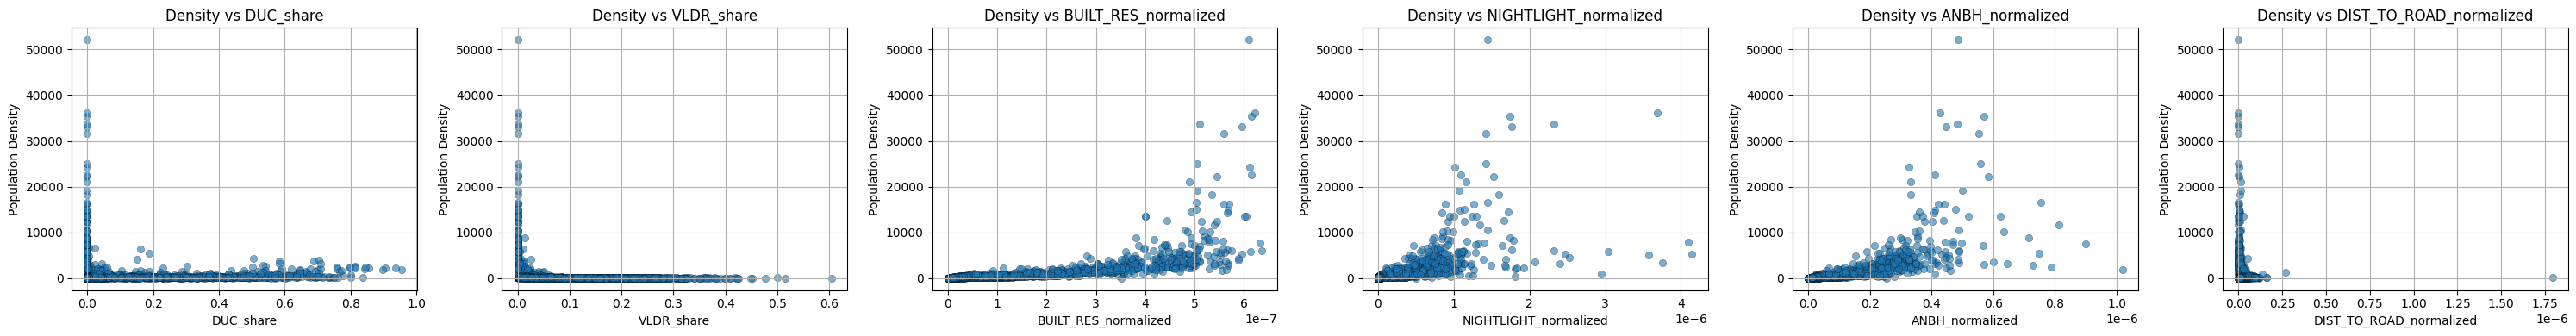

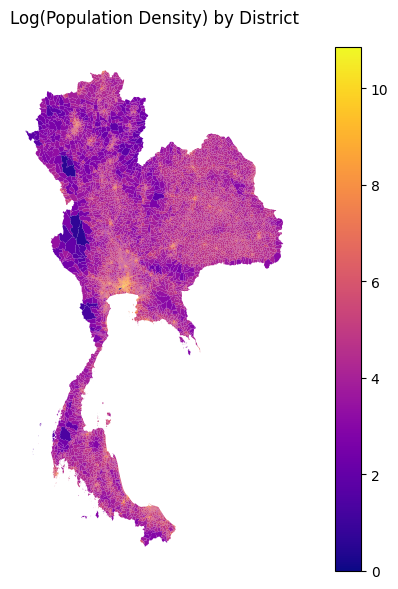

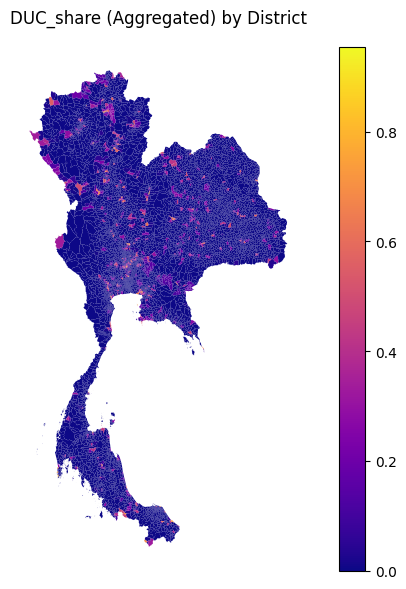

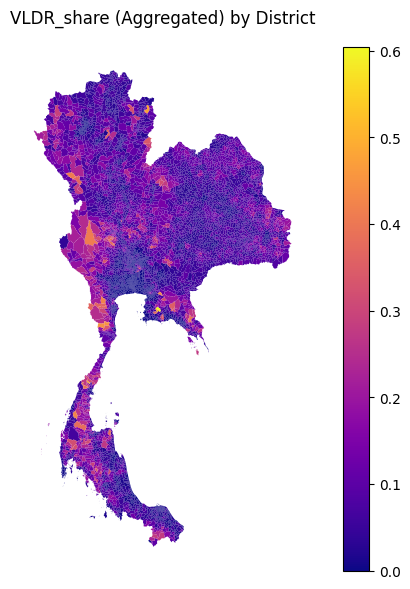

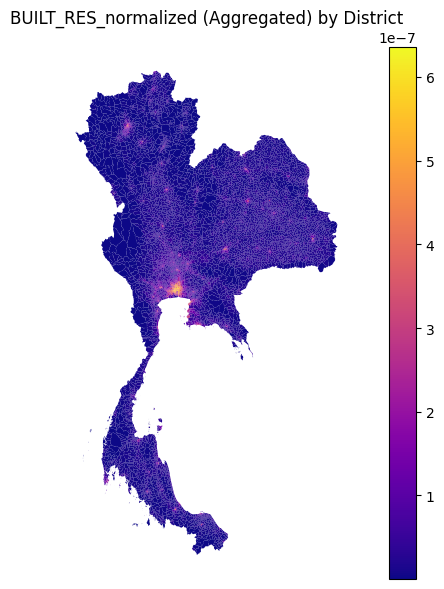

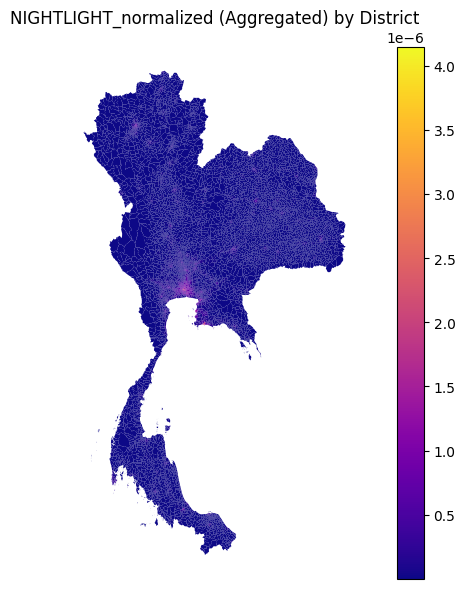

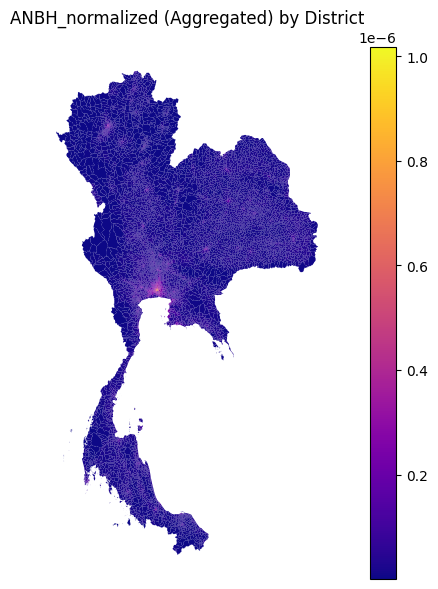

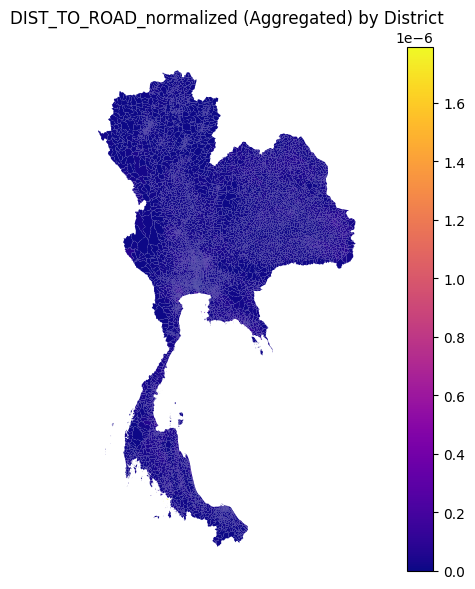

,Feature,Importance
2,BUILT_RES_normalized,0.625971
4,ANBH_normalized,0.217785
3,NIGHTLIGHT_normalized,0.113140
5,DIST_TO_ROAD_normalized,0.037730
1,VLDR_share,0.004085
0,DUC_share,0.001289


RMSE: 386.57
Relative RMSE: 107.33%


array([0., 0., 0., ..., 0., 0., 0.], shape=(51685536,))

In [8]:
# === Apply weights and sum
covariate_keys = ['DUC_share', 'VLDR_share', 'BUILT_RES_normalized', 'NIGHTLIGHT_normalized', 'ANBH_normalized', 'DIST_TO_ROAD_normalized']

model_df, model_linear, rmse_linear, rrmse_linear = dasymetric.model_poprf(
    covar_arrays=covar_arrays,
    area_raster=subdistrict_raster,
    area_id_column='subdist_int',
    area_level='ADM3',
    gdf_uc=gdf_subdist_uc,
    covariate_keys=covariate_keys,
    plot=True
)
# data, model_linear, trace, rmse_linear, rrmse_linear, importance_df = dasymetric.model_pop_bayesian(
#     covar_arrays=covar_arrays,
#     area_raster=subdistrict_raster,
#     area_id_column='subdist_int',
#     area_level='ADM3',
#     gdf_uc=gdf_subdist_uc,
#     covariate_keys=covariate_keys,
#     plot=True
# )

print(f"RMSE: {rmse_linear:,.2f}")
print(f"Relative RMSE: {rrmse_linear:.2%}")

grid_mask = district_raster.flatten() > 0  # Optional if you want to predict only valid pixels
X_grid = np.stack([covar_arrays[cov].flatten() for cov in covariate_keys], axis=1)

X_valid = X_grid[grid_mask]

dens_valid_pred = model_linear.predict(X_valid) # y-predicted = density = pop / km2
grid_area = 0.01
pop_predicted = dens_valid_pred * grid_area
mask_res = (built_res[district_raster > 0] > 0).flatten()
pop_predicted[~mask_res] = 0
pop_predicted /= pop_predicted.sum()
pop_predicted *= total_uc

display(pop_predicted)

base_grid_path = 'data/gridded_pop/covariates/BLANK_100m.tif'
with rasterio.open(base_grid_path) as base:
    base_shape = (base.height, base.width)
    base_transform = base.transform
    base_crs = base.crs
    
pop_grid = np.zeros(height * width, dtype=np.float32)
pop_grid[grid_mask] = pop_predicted  # insert predicted values
pop_grid = pop_grid.reshape((base.height, base.width))  # reshape to 2D

with rasterio.open(
    'data/gridded_pop/covariates/GRIDDED_POP.tif',
    'w',
    driver='GTiff',
    height=base.height,
    width=base.width,
    count=1,
    dtype=pop_grid.dtype,
    crs='EPSG:32647',
    transform=base_transform,
) as dst:
    dst.write(pop_grid, 1)

# print('Prediction is finished.')

# for cov in covariate_keys:
#     sns.kdeplot(X_valid[:, covariate_keys.index(cov)], label=f'Grid: {cov}')
#     sns.kdeplot(model_df[cov], label=f'District: {cov}', linestyle='--')
#     plt.title(f'Distribution of {cov}')
#     plt.legend()
#     plt.show()

# plt.hist(dens_valid_pred, bins=100, log=True)
# plt.title('Predicted Density Distribution')
# plt.xlabel('Density (pop/km²)')
# plt.ylabel('Pixel count')
# plt.show()

RMSE District: 1224
Relative RMSE District: 304.12%
MAE District: 170


,dist_int,pop_predicted,ADM2_PCODE,geometry,m_population,area_km2,density,density_predicted
0,1001,29358.3,1001,"POLYGON ((662263.213 1519594.56, 662163.209 15...",17963.0,5.389088,3333.217087,5447.730736
1,1002,55294.5,1002,"POLYGON ((664304.385 1526127.491, 664383.8 152...",53493.0,11.366450,4706.218725,4864.711482
2,1003,77605.0,1003,"POLYGON ((706774.567 1542610.081, 706771.612 1...",91347.0,237.563473,384.516184,326.670591
3,1004,24406.1,1004,"POLYGON ((664040.151 1517063.009, 664039.968 1...",45527.0,4.031673,11292.333450,6053.590604
4,1006,96978.3,1006,"POLYGON ((676080.628 1528348.043, 676085.753 1...",70072.0,27.556617,2542.837521,3519.238211
...,...,...,...,...,...,...,...,...
919,9609,4726.9,9609,"POLYGON ((809870.338 673685.325, 810071.182 67...",21527.0,526.794660,40.864120,8.972946
920,9610,23779.7,9610,"POLYGON ((836531.955 680272.524, 836546.572 68...",69238.0,133.726573,517.757978,177.823296
921,9611,12563.0,9611,"POLYGON ((822806.79 694818.18, 822819.41 69452...",47918.0,386.991202,123.821937,32.463270
922,9612,8337.8,9612,"POLYGON ((800322.891 684393.908, 800308.076 68...",34860.0,591.712110,58.913785,14.090974


RMSE Subdistrict: 1056
Relative RMSE Subdistrict: 293.18%
MAE Subdistrict: 153


,subdist_int,pop_predicted,ADM3_PCODE,geometry,m_population,area_km2,density,density_predicted
0,10010100,4912.8,10010100,"POLYGON ((661579.024 1521418.711, 661615.761 1...",1338.0,1.536315,870.915235,3197.782038
1,10010200,3648.7,10010200,"POLYGON ((662319.106 1520362.498, 662360.982 1...",3859.0,0.726025,5315.242610,5025.583237
2,10010300,1873.1,10010300,"POLYGON ((662329.198 1520380.999, 662319.106 1...",1228.0,0.211727,5799.931477,8846.784731
3,10010400,1354.1,10010400,"POLYGON ((662773.082 1521004.69, 662732.96 152...",1176.0,0.229752,5118.558800,5893.741897
4,10010500,1217.8,10010500,"POLYGON ((662036.744 1521201.399, 662035.386 1...",1183.0,0.150417,7864.820468,8096.177824
...,...,...,...,...,...,...,...,...
7421,96120300,1188.1,96120300,"POLYGON ((800070.078 682826.08, 800157.206 682...",5943.0,50.448422,117.803486,23.550786
7422,96120400,1847.6,96120400,"POLYGON ((797267.01 673478.429, 797262.382 673...",7318.0,380.612410,19.226909,4.854282
7423,96130100,3694.0,96130100,"POLYGON ((815621.227 697042.626, 815792.242 69...",10556.0,58.992948,178.936642,62.617654
7424,96130200,4114.9,96130200,"POLYGON ((816168.399 688499.285, 816303.649 68...",16515.0,72.514504,227.747541,56.745889


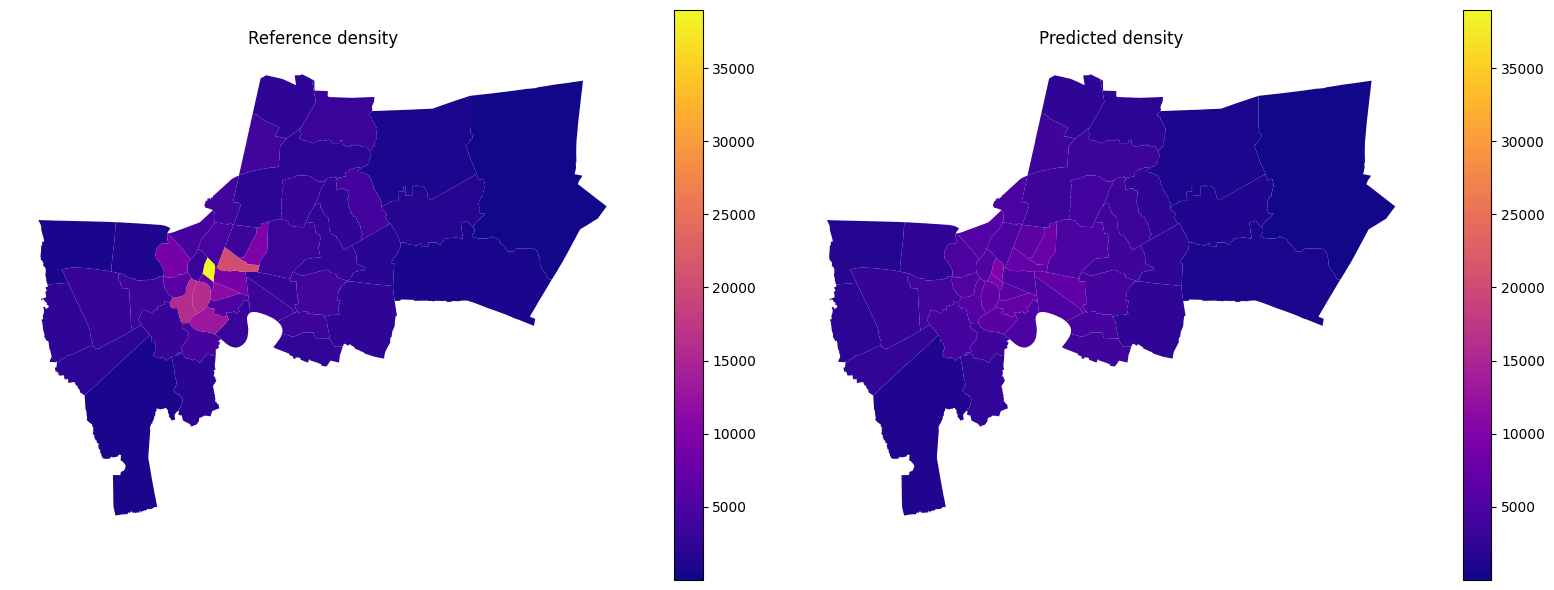

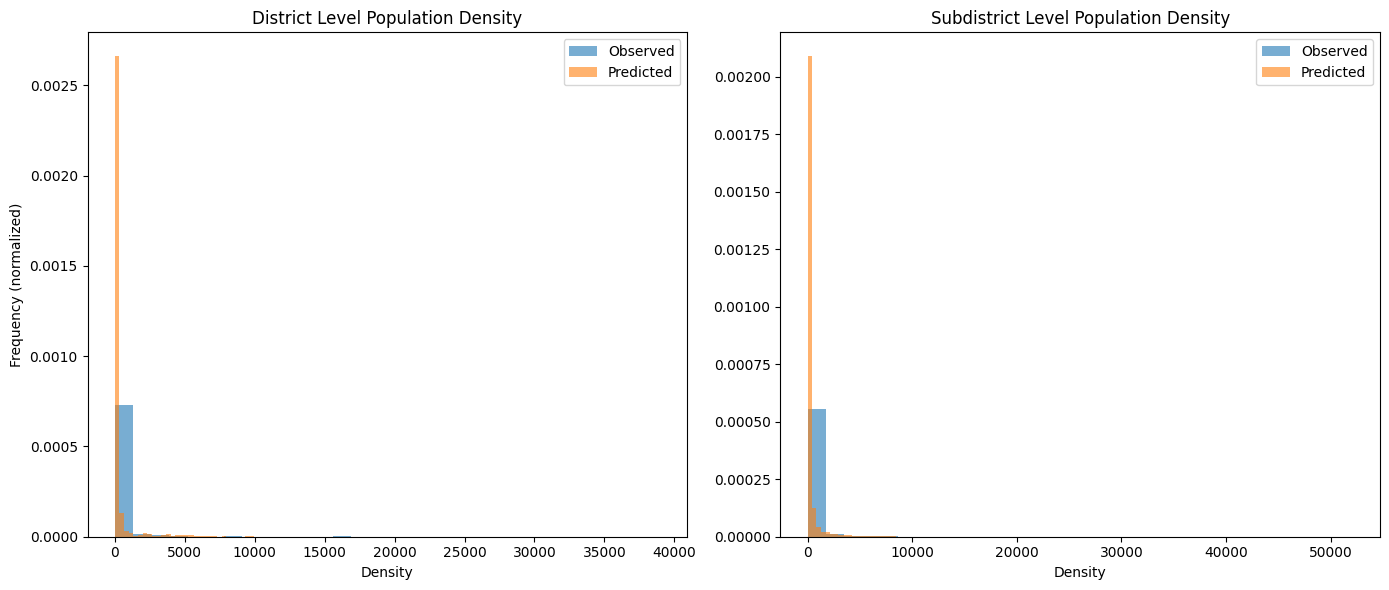

In [9]:
# Aggregate by district
pop_flat = pop_predicted
dist_flat = district_raster.flatten()
subdist_flat = subdistrict_raster.flatten()
dist_valid = dist_flat[grid_mask]
subdist_valid = subdist_flat[grid_mask]
max_id_dist = dist_valid.max()
max_id_subdist = subdist_valid.max()
pop_sum_per_district = np.bincount(dist_valid, weights=pop_flat, minlength=max_id_dist + 1)
pop_sum_per_subdistrict = np.bincount(subdist_valid, weights=pop_flat, minlength=max_id_subdist + 1)
nonzero_ids_dist = np.nonzero(pop_sum_per_district)[0]
nonzero_ids_subdist = np.nonzero(pop_sum_per_subdistrict)[0]
pop_dist_df = pd.DataFrame({
    'dist_int': nonzero_ids_dist.astype(str),  # convert to string to match ADM2_PCODE
    'pop_predicted': np.round(pop_sum_per_district[nonzero_ids_dist], 1)
})
pop_subdist_df = pd.DataFrame({
    'subdist_int': nonzero_ids_subdist.astype(str),  # convert to string to match ADM2_PCODE
    'pop_predicted': np.round(pop_sum_per_subdistrict[nonzero_ids_subdist], 1)
})

pop_dist_df = pop_dist_df.merge(
    gdf_dist_uc[['ADM2_PCODE', 'geometry', 'm_population', 'area_km2', 'density']],
    how='left',
    left_on='dist_int',
    right_on='ADM2_PCODE'
)
pop_dist_df['density_predicted'] = pop_dist_df['pop_predicted'] / pop_dist_df['area_km2']

pop_subdist_df = pop_subdist_df.merge(
    gdf_subdist_uc[['ADM3_PCODE', 'geometry', 'm_population', 'area_km2', 'density']],
    how='left',
    left_on='subdist_int',
    right_on='ADM3_PCODE'
)
pop_subdist_df['density_predicted'] = pop_subdist_df['pop_predicted'] / pop_subdist_df['area_km2']

# Compute accuracy parameters
rmse_dist = np.sqrt(((pop_dist_df['density_predicted'] - pop_dist_df['density']) ** 2).mean())
mae_dist = (np.abs(pop_dist_df['density_predicted'] - pop_dist_df['density'])).mean()
mean_dist = np.mean(pop_dist_df['density'])
relative_rmse_dist = rmse_dist / mean_dist

rmse_subdist = np.sqrt(((pop_subdist_df['density_predicted'] - pop_subdist_df['density']) ** 2).mean())
mae_subdist = (np.abs(pop_subdist_df['density_predicted'] - pop_subdist_df['density'])).mean()
mean_subdist = np.mean(pop_subdist_df['density'])
relative_rmse_subdist = rmse_subdist / mean_subdist

# Print results
print(f'RMSE District: {rmse_dist:.0f}')
print(f'Relative RMSE District: {relative_rmse_dist:.2%}')
print(f'MAE District: {mae_dist:.0f}')
display(pop_dist_df)

print(f'RMSE Subdistrict: {rmse_subdist:.0f}')
print(f'Relative RMSE Subdistrict: {relative_rmse_subdist:.2%}')
print(f'MAE Subdistrict: {mae_subdist:.0f}')
display(pop_subdist_df)

# Create 2 subplots for validate and predicted one with the same scale

gdf_plot = gpd.GeoDataFrame(pop_dist_df.reset_index(), geometry='geometry', crs=gdf_dist_uc.crs)
gdf_bkk = gdf_plot[gdf_plot['ADM2_PCODE'].str.startswith('10')]

# Define common vmin/vmax for color scale
vmin = min(gdf_plot['density'].min(), gdf_plot['density'].min())
vmax = max(gdf_plot['density'].max(), gdf_plot['density'].max())

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

gdf_bkk.plot(column='density', cmap='plasma', legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Reference density')
axes[0].axis('off')

gdf_bkk.plot(column='density_predicted', cmap='plasma', legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted density')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# District level
axes[0].hist(pop_dist_df['density'], bins=30, alpha=0.6, label='Observed', density=True)
axes[0].hist(pop_dist_df['density_predicted'], bins=30, alpha=0.6, label='Predicted', density=True)
axes[0].set_title('District Level Population Density')
axes[0].set_xlabel('Density')
axes[0].set_ylabel('Frequency (normalized)')
axes[0].legend()

# Subdistrict level
axes[1].hist(pop_subdist_df['density'], bins=30, alpha=0.6, label='Observed', density=True)
axes[1].hist(pop_subdist_df['density_predicted'], bins=30, alpha=0.6, label='Predicted', density=True)
axes[1].set_title('Subdistrict Level Population Density')
axes[1].set_xlabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

In [57]:
base_grid_path = 'data/gridded_pop/covariates/BLANK_100m.tif'

with rasterio.open(base_grid_path) as base:
    base_shape = (base.height, base.width)
    base_transform = base.transform
    base_crs = base.crs

worldpop_path = f"data/gridded_pop/tha_ppp_2020_UNadj_constrained.tif"
save_path = f"data/gridded_pop/tha_ppp_2020_UNadj_constrained_100m.tif"

with rasterio.open(worldpop_path) as src:
    data = src.read(1).astype(np.float32)
    nodata = src.nodata
    aligned = np.zeros(base_shape, dtype=np.float32)

    reproject(
        source=data,
        destination=aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_transform,
        dst_crs=base_crs,
        src_nodata=nodata,
        dst_nodata=0,
        resampling=Resampling.bilinear
    )

# Save resampled raster
with rasterio.open(
    save_path, 'w',
    driver='GTiff',
    height=base_shape[0],
    width=base_shape[1],
    count=1,
    dtype='float32',
    crs=base_crs,
    transform=base_transform,
    nodata=src.nodata
) as dst:
    # Replace masked or invalid values with nodata
    aligned[np.isnan(aligned)] = src.nodata
    dst.write(aligned, 1)

ref_path = f"data/gridded_pop/tha_ppp_2020_UNadj_constrained_100m.tif"
with rasterio.open(ref_path) as src:
    ref = src.read(1).astype(np.float32)
    ref_nodata = src.nodata
ref[ref == src.nodata] = 0

district_path = 'data/gridded_pop/covariates/DISTRICT_100m.tif'
with rasterio.open(district_path) as src:
    districts = src.read(1).astype(np.float32)

grid_mask = districts.flatten() > 0
ref_flatten = ref.flatten()
ref_masked = ref_flatten[grid_mask]

ref_normalized = ref_masked / ref_masked.sum()
pop_normalized = pop_predicted / pop_predicted.sum()
display(ref_normalized.mean())
display(pop_normalized.mean())

rmse = np.sqrt(np.mean((pop_normalized - ref_normalized) ** 2))
mean = np.mean(ref_normalized)
relative_rmse = rmse / mean

print(f'Relative RMSE (with WorldPop): {relative_rmse:.2%}')


np.float32(1.934778e-08)

np.float64(1.934777265345571e-08)

Relative RMSE (with WorldPop): 554.59%
